In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [2]:
raw_df = pd.read_csv('data/zillow_data.csv')

Filter only for Texas
<br>Drop Metro because there were many nulls, and it was redundant with other location data 
<br> Drop regionID and SizeRank because values were specific to Zillow 

In [3]:
raw_df = raw_df[raw_df['State']=='TX']

In [4]:
#Calculate historical return on investment
raw_df['ROI']= (raw_df['2018-04']/raw_df['1996-04'])-1
raw_df['ROI']


#Calculate standard deviation of monthly values
raw_df['std']=raw_df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
raw_df['mean']=raw_df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
raw_df['CV']=raw_df['std']/raw_df['mean']

#Show calculated values
raw_df[['RegionName','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(raw_df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = raw_df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = raw_df[raw_df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['RegionName','ROI','CV']]

count    989.000000
mean       0.167433
std        0.041415
min        0.045182
25%        0.142279
50%        0.165783
75%        0.189448
max        0.361446
Name: CV, dtype: float64

CV upper limit: 0.17479440936725238

 Best 5 Zipcodes:


,RegionName,ROI,CV
5130,77020,1.641221,0.170703
6646,76104,1.304225,0.171104
9106,75956,1.255220,0.170555
225,75217,1.248485,0.169633
4123,77091,1.208904,0.170921


In [5]:
raw_df.drop(['RegionID','Metro','State','SizeRank'],axis=1, inplace=True)


In [6]:
raw_df

,RegionName,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,CV
1,75070,McKinney,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,315000,316600,318100,319600,321100,321800,0.365295,33537.101427,219655.849057,0.152680
2,77494,Katy,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,320800,321200,321200,323000,326900,329900,0.567966,37730.794353,262110.566038,0.143950
4,79936,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,120300,120300,120300,120500,121000,121500,0.571798,18167.079218,101875.471698,0.178326
5,77084,Houston,Harris,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,...,162800,162800,162800,162900,163500,164300,0.729474,17242.109812,121185.283019,0.142279
8,77449,Katy,Harris,95400.0,95600.0,95800.0,96100.0,96400.0,96700.0,96800.0,...,170900,172300,173300,174200,175400,176200,0.846960,18603.288493,126530.188679,0.147026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,76941,Mertzon,Irion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123500,124700,124300,122600,121600,121600,NaN,13734.029878,99318.367347,0.138283
14472,79313,Anton,Hockley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58900,61500,63000,63600,63500,63300,NaN,5286.674724,54424.675325,0.097137
14492,79355,Plains,Yoakum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99700,97700,95800,94600,94000,93500,NaN,12929.465872,78967.346939,0.163732
14599,79366,Ransom Canyon,Lubbock,134500.0,134500.0,134400.0,134400.0,134300.0,134200.0,134200.0,...,251300,251500,251700,252500,255000,257500,0.914498,31276.315584,172420.377358,0.181396


In [7]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['RegionName', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [8]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionName  255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   ROI         250160 non-null  float64       
 4   std         255096 non-null  float64       
 5   mean        255096 non-null  float64       
 6   CV          255096 non-null  float64       
 7   date        255096 non-null  datetime64[ns]
 8   value       255096 non-null  float64       
 9   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 21.4+ MB


In [9]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,RegionName,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [10]:
# Select the first quantile
q1 = df['value'].quantile(.25)

# Select the third quantile
q3 = df['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered =df[(df['value']>=q1) 
             & (df['value']<=q3)]
filtered

,RegionName,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018


In [11]:
df = pd.DataFrame(filtered)
df 

,RegionName,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,79019,Claude,Armstrong,NaN,6615.560732,76994.897959,0.085922,84400.0,2018
2018-04-01,77577,Liverpool,Brazoria,1.457990,22188.730901,96658.867925,0.229557,149200.0,2018
2018-04-01,77663,Kountze,Hardin,0.727907,17632.899715,120896.226415,0.145852,148600.0,2018


# EDA

Create DataFrame to perform stationarity checks and transformations

In [12]:
df_prices = pd.DataFrame(df['value'], index = df.index)
df_prices

,value
date,
1996-04-01,95000.0
1996-04-01,95400.0
1996-04-01,138900.0
1996-04-01,141400.0
1996-04-01,138500.0
...,...
2018-04-01,84400.0
2018-04-01,149200.0
2018-04-01,148600.0


**Mean prices by year**

<AxesSubplot:xlabel='date'>

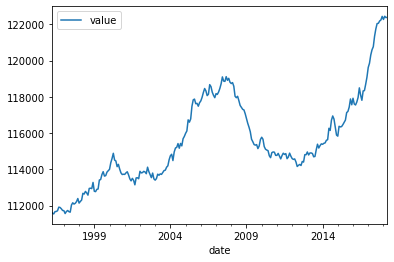

In [13]:
avg_prices = df_prices.groupby('date').aggregate({'value':'mean'})
avg_prices.plot()

<AxesSubplot:xlabel='date'>

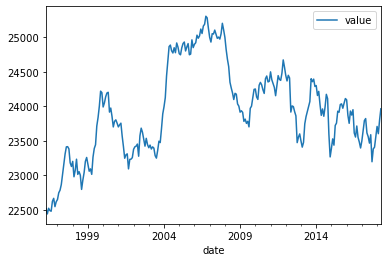

In [14]:
std_prices = df_prices.groupby('date').aggregate({'value':'std'})
std_prices.plot()

<AxesSubplot:xlabel='date'>

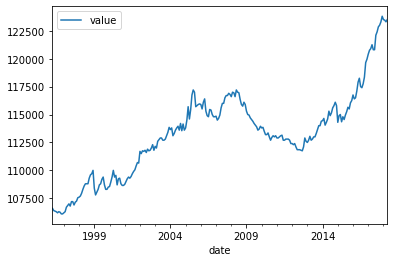

In [15]:
med_prices = df_prices.groupby('date').aggregate({'value':'median'})
med_prices.plot()

In [20]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

Results of Dickey-Fuller Test: 

Test Statistic                    -33.385605
p-value                             0.000000
#Lags Used                         72.000000
Number of Observations Used    127623.000000
Critical Value (1%)                -3.430401
Critical Value (5%)                -2.861563
Critical Value (10%)               -2.566782
dtype: float64


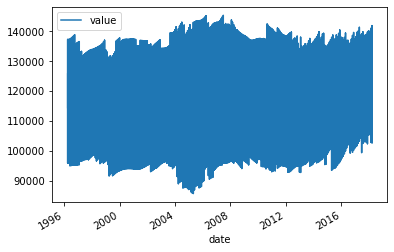

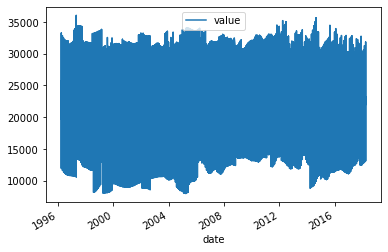

In [21]:
results = stationarity_check(df_prices)
results

**Log Transformations**

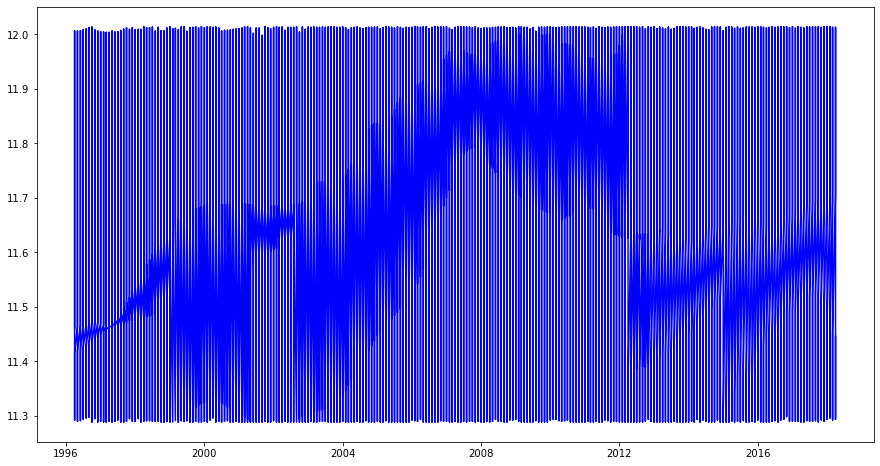

In [27]:
df_log = np.log(df_prices)
fig = plt.figure(figsize=(15,8))
plt.plot(df_log, color='blue');


**Weighted Rolling Mean**

<AxesSubplot:xlabel='date'>

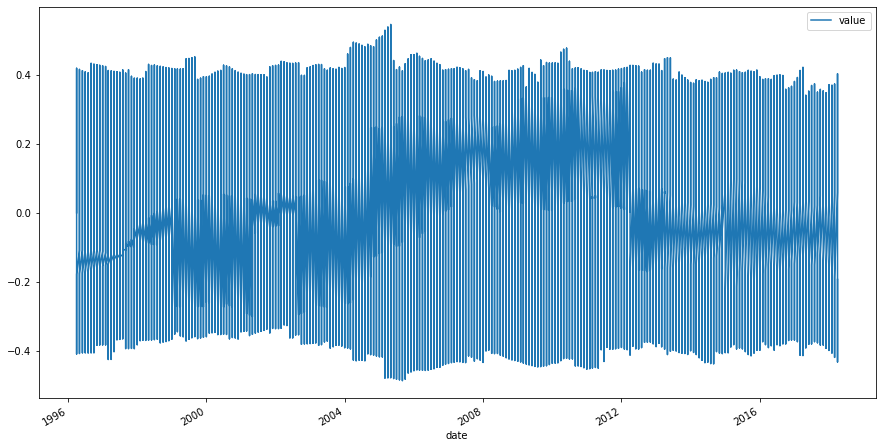

In [29]:
weight_roll_mean = df_log.ewm(halflife=4).mean()
df_log_wrm = df_log - weight_roll_mean
df_log_wrm.plot(figsize=(15,8))



In [34]:
type(df_log_wrm.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [32]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_log_wrm, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:               127696
Model:                 ARIMA(1, 0, 0)   Log Likelihood               39618.559
Date:                Mon, 04 Oct 2021   AIC                         -79231.117
Time:                        17:14:59   BIC                         -79201.845
Sample:                             0   HQIC                        -79222.330
                             - 127696                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.848e-09      0.000   6.13e-06      1.000      -0.001       0.001
ar.L1         -0.0700      0.003    -25.212      0.000      -0.075      -0.065
sigma2         0.0315      0.000    188.751      0.0